In [1]:
import SFCPurifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nmslib

In [2]:
df_ = pd.read_csv(r'C:\PLT\Plt_200k_h2.csv', delimiter=';')
x_DB, y_DB = np.array(df_)[:, 5 + 4: 4 + 81], np.array(df_)[:, :4]
drawer = SFCPurifier.Drawer()
clus = SFCPurifier.AutoGater()
pur = SFCPurifier.Purifier()

sova = SFCPurifier.InverseSpheresSolver()
sova.initParams(660, np.array(range(50,800)) / 10,rf_path = 'tf.txt')

db_0 = np.load('db[0].txt.npz')['arr_0']
db_1 = np.load('db[1].txt.npz')['arr_0']
sova.initModel(db_0, db_1)

In [ ]:
def fullPipeline(paths):

    for path in paths:
        data = pur.openBigPocketBinFile(path + r'\3D_pockets_uint16.bin', peak_height = 1000)
        #data = pur.openBinFile(path + r'\3D_pockets_uint16.bin')

        forward = data[:,1,:]
        backward = data[:,2,:]
        
        forward = pur.zeroDeletion(forward)[:,1700:2300]
        backward = pur.zeroDeletion(backward)[:,1300:2900]

        if path == paths[0]:
            cm_map, cm_scaler = clus.makeMap(forward_array=forward, backward_array=forward, map_type='CM', norm_type="MinMax")
        else:
            cm_map, _ = clus.makeMap(forward_array=forward, backward_array=forward, map_type='CM', norm_type=cm_scaler)

        res_labels = clus.makeAutoGating(cm_map,BOUNDS = [(0.03, 0.04), (10, 25)])
        drawer.drawGating(cm_map, map_names=['Forward_int','Backward_int'],labels=res_labels)

        latex_labels = int(input('Выберете кластер латексов'))
        plt_labels = [int(i) for i in input('Выберете кластер тромбоцитов').split()]

        latex_forward = forward[res_labels == latex_labels]
        res = sova.KNNSpheresFit(latex_forward)

        forward = data[:,1,:]
        forward = pur.zeroDeletion(forward)
        time = np.array(range(5000)) / 750000

        plt_forw_list = []
        plt_full_labels = []
        for lb in plt_labels:
            plt_forw_list.append(forward[res_labels == lb])
            plt_full_labels.append(np.array(range(len(forward)))[res_labels == lb])

        plt_forward = np.vstack(plt_forw_list)
        plt_full_labels = np.hstack(plt_full_labels)
 

        latex_forward = forward[res_labels == latex_labels]
        latex_th_forward = db_0[np.array(res[1])]


        plt.plot(latex_forward[:,1700:2300][1], '*')
        plt.plot(latex_th_forward[1])
        plt.show()

        angle_range = np.array(range(5,81))
        
        latex_inds = sova.trace2ind(angle_range, time, latex_forward, args ={'v':np.mean(np.array(res[0])[:,2]), 'l0':np.mean(np.array(res[0])[:,3])})
        latex_th_inds = sova.trace2ind(angle_range, time[1700:2300], latex_th_forward, args ={'v':np.mean(np.array(res[0])[:,2]), 'l0':np.mean(np.array(res[0])[:,3])})
        plt_inds = sova.trace2ind(angle_range, time, plt_forward, args ={'v':np.mean(np.array(res[0])[:,2]), 'l0':np.mean(np.array(res[0])[:,3])})
        
        pltSolver = SFCPurifier.InverseSpheresSolver()
        mf = pltSolver.weightM(angle_range)

        # alpl = []
        # for i in range(len(latex_th_inds)):
        #     x_, y_ = latex_inds[i] * mf, latex_th_inds[i] * mf
        #     alpl.append(np.dot(x_, y_) / np.dot(y_, y_))

        plt_inds = plt_inds / np.mean(alpl)
        plt_exp = plt_inds * mf 

        pltSolver.initModel((x_DB * mf)[:,5:] , y_DB, space = 'l2')
        plt_res = pltSolver.KNNFit(plt_exp[:,5:])
        plt_db = x_DB[plt_res[1]] * mf

        total_inds = sova.trace2ind(angle_range, time, forward, args ={'v':np.mean(np.array(res[0])[:,2]), 'l0':np.mean(np.array(res[0])[:,3])})
        df_exp = pd.DataFrame(data=total_inds, columns=angle_range)
        
        df_exp['CMX'] = cm_map[:,0]
        df_exp['CMY'] = cm_map[:,1]
        df_exp['Label'] = res_labels

        df_spheres = pd.DataFrame(data = latex_inds, columns=angle_range, index=np.array(range(len(forward)))[res_labels == latex_labels])
        df_spheres['d'] = np.array(res[0])[:,0]
        df_spheres['n'] = np.array(res[0])[:,1]
        df_spheres['v'] = np.array(res[0])[:,2]
        df_spheres['l0'] = np.array(res[0])[:,3]
        df_spheres['alpha'] = alpl

        df_plt = pd.DataFrame(data = plt_inds, columns=angle_range, index=plt_full_labels)
        
        # df_spheres.to_csv(path + r'\spheres.csv', sep = ';')
        # df_exp.to_csv(path + r'\exp.csv', sep = ';')
        # df_plt.to_csv(path + r'\plt.csv', sep = ';')

        pass

[ 0.03351852 11.94444444]


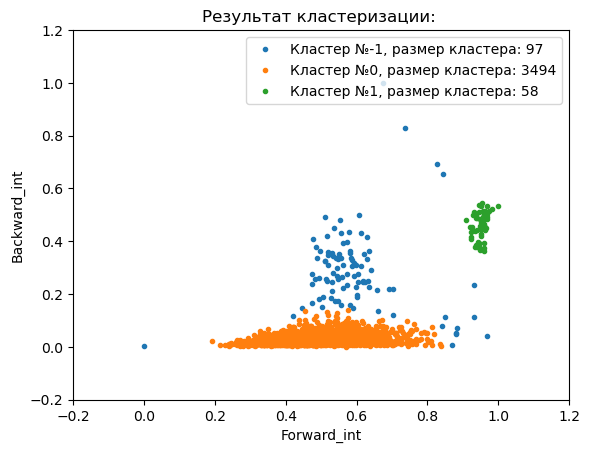

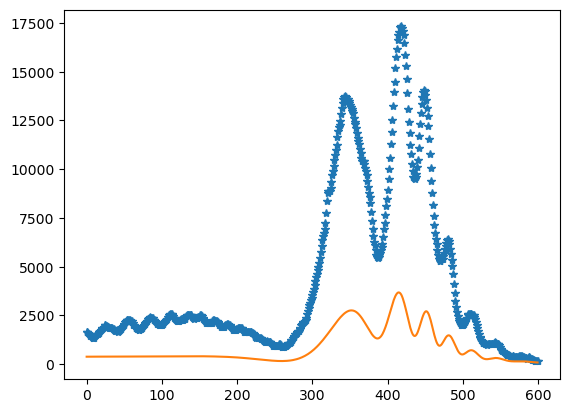

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [4]:
# paths = [
#     r'C:\20240813\plt_nat\3D_pockets_uint16.bin',
#     r'C:\20240813\plt_agr_3min\3D_pockets_uint16.bin',
#     r'C:\20240813\plt_agr_20min\3D_pockets_uint16.bin',
#     r'C:\20240813\plt_agr_30min\3D_pockets_uint16.bin',
#     r'C:\20240813\plt_agr_50min\3D_pockets_uint16.bin'
# ]

# paths = [
#     "C:\20240813\plt_nat"
# ]
paths = [
    r'C:\20241114\1to8 seria\plt_nat_speed10',
    r'C:\20241114\1to8 seria\plt_agr_1_speed10',
    r'C:\20241114\1to8 seria\plt_agr_2_speed10']
fullPipeline(paths)

In [ ]:
pltSolver = SFCPurifier.InverseSpheresSolver()
pltSolver.initModel(x_DB * pltSolver.weightM(np.array(range(5, 81))) , y_DB)

In [ ]:
plt_res = pltSolver.KNNFit(plt_inds * pltSolver.weightM(np.array(range(5,66))))

NameError: name 'plt_inds' is not defined

In [8]:
x_, y_ = plt_inds [6] * pltSolver.weightM(np.array(range(5,66))), x_DB[plt_res[1][6]] * pltSolver.weightM(np.array(range(5,66)))

plt.plot(x_ , '*')
plt.plot(y_ * np.dot(x_, y_) / np.dot(y_, y_))


NameError: name 'plt_inds' is not defined

In [34]:
plt_db = x_DB[plt_res[1]] * pltSolver.weightM(np.array(range(5,66)))
plt_exp = plt_inds * pltSolver.weightM(np.array(range(5,66)))

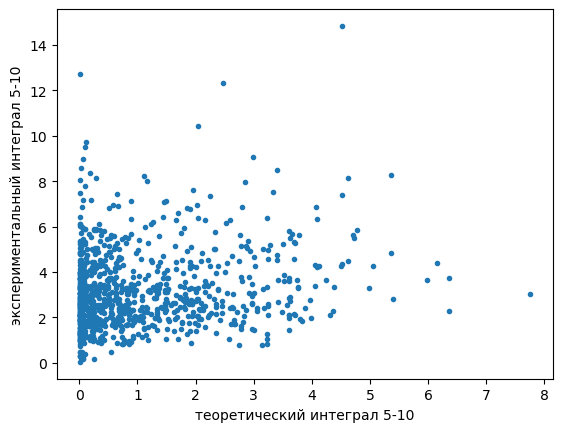

In [35]:
plt.plot(np.sum(plt_db[:,:5], axis=1), np.sum(plt_exp[:,:5], axis=1), '.')
plt.xlabel('теоретический интеграл 5-10')
plt.ylabel('экспериментальный интеграл 5-10')
plt.show()

In [38]:
alp = []
for i in range(len(plt_inds)):
    x_, y_ = plt_inds[i] * pltSolver.weightM(np.array(range(5,66))), x_DB[plt_res[1][i]] * pltSolver.weightM(np.array(range(5,66)))
    alp.append(np.dot(x_, y_) / np.dot(y_, y_))

In [39]:
np.mean(alp)

51.31561920419143

In [ ]:
plt_exp_ = plt_exp* np.mean(alp) 

Text(0.5, 1.0, 'Распределение MSE в диапазоне 5-10')

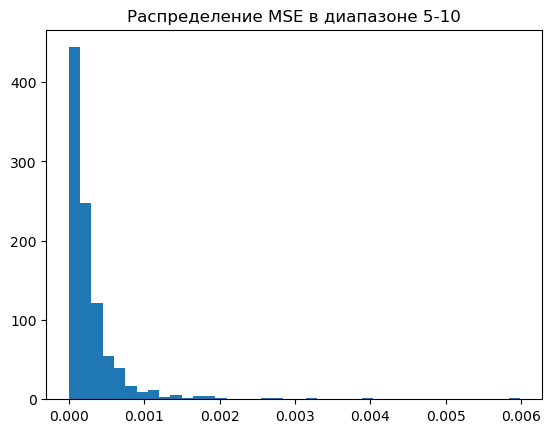

In [ ]:
plt.hist(np.sum(((plt_db* pltSolver.weightM(np.array(range(5,66))))[:,:5] - (plt_exp_ * pltSolver.weightM(np.array(range(5,66))))[:,:5]) ** 2, axis=1), bins=40)
plt.title('Распределение MSE в диапазоне 5-10')

In [ ]:
alp = []
for i in range(len(plt_inds)):
    x_, y_ = plt_inds[i] * pltSolver.weightM(np.array(range(5,66))), x_DB[xxxx[1][i]] * pltSolver.weightM(np.array(range(5,66)))
    alp.append(np.dot(x_, y_) / np.dot(y_, y_))